In [2]:
from disease_prediction.data import datasets as ds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = ds.load_datasets(subsets=['train', 'validate', 'test'],
                       directory='/Users/rebeccaceppas/Desktop/code/disease_prediction/disease_prediction/data/')

_df = df['train']
df_test = df['test']
df_validate = df['validate']

In [4]:
## combining validation and training set so I can do cross-validation

df_train = pd.concat(
    [_df, df_validate],
    axis=0, 
    ignore_index=True
    )

## removing ebola from possible diseases
df_train.drop(index=df_train.loc[df_train.PATHOLOGY == 'Ebola'].index,
              inplace=True)

## removing lesion_peeling, pain_radiate columns
df_train.drop(columns=['lesions_peeling', 'pain_radiate'], inplace=True)


In [5]:
## one hot encoding

columns = list(df_train.columns)

numerical = []
categorical = []

for col in columns:

    if df_train[col].dtype == 'int64':
        numerical.append(col)

    elif df_train[col].dtype == 'object':
        categorical.append(col)

categorical.remove('PATHOLOGY')
categorical.remove('pain_somewhere')
categorical.remove('lesion_location')

df_train = pd.get_dummies(df_train, 
                         columns=categorical, 
                         dtype=int)

## pain_somewhere, lesion_location and swelling_location -> Y or N to simplify

df_train['lesion_location'] = (df_train['lesion_location'] != 'nowhere').astype(int)
df_train['pain_somewhere'] = (df_train['pain_somewhere'] != 'nowhere').astype(int)

In [6]:
df_train.describe()

,index,AGE,swollen_nodes,std,sweating,diarrhea,pain,pain_somewhere,pain_intensity,pain_precise,...,swelling_location_dorsal aspect of the foot(L),swelling_location_dorsal aspect of the foot(R),swelling_location_forehead,swelling_location_nose,swelling_location_nowhere,swelling_location_sole(L),swelling_location_sole(R),swelling_location_thigh(L),swelling_location_thigh(R),swelling_location_toe (1)(L)
count,2.275990e+05,227599.000000,227599.000000,227599.000000,227599.000000,227599.000000,227599.000000,227599.000000,227599.000000,227599.000000,...,227599.000000,227599.000000,227599.000000,227599.000000,227599.000000,227599.000000,227599.000000,227599.000000,227599.000000,227599.000000
mean,4.583522e+05,37.757068,0.041898,0.021134,0.036200,0.039526,0.154966,0.154966,0.792249,0.749353,...,0.009069,0.007948,0.000554,0.020114,0.944319,0.004209,0.006459,0.000035,0.000004,0.000009
std,3.129796e+05,23.401137,0.200357,0.143830,0.186787,0.194842,0.361873,0.361873,2.025563,1.996498,...,0.094797,0.088798,0.023522,0.140392,0.229306,0.064741,0.080106,0.005929,0.002096,0.002964
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.545310e+05,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.404650e+05,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.309875e+05,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.023494e+06,109.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Random forest with all features

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [8]:
df_tt, df_val, = train_test_split(df_train, 
                                            test_size=0.2,
                                            shuffle=True,
                                            random_state=740,
                                            stratify=df_train.PATHOLOGY)

X_tt = df_tt.drop(columns='PATHOLOGY')
y_tt = df_tt.PATHOLOGY
X_val = df_val.drop(columns='PATHOLOGY')
y_val = df_val.PATHOLOGY

# Original random forest

In [9]:
rf1 = RandomForestClassifier(
    n_estimators = 500, # number of trees in ensemble
    max_depth = 20, # max_depth of each tree
    min_samples_leaf = 5, 
    bootstrap= True, # sampling with replacement
    max_samples = 2500, # number of training samples selected with replacement to build tree
    random_state = 740 # for consistency
    )

In [10]:
rf1.fit(X_tt, y_tt)
y_pred1 = rf1.predict(X_val)

In [11]:
print(classification_report(y_val, y_pred1))

                         precision    recall  f1-score   support

     Allergic sinusitis       0.86      0.87      0.86      5668
            Anaphylaxis       0.98      0.39      0.56      6295
                 Chagas       1.00      0.23      0.38      2075
HIV (initial infection)       0.41      0.75      0.53      6573
              Influenza       0.84      0.21      0.34      6080
        Localized edema       0.52      1.00      0.68      6304
                    SLE       1.00      0.30      0.46      2689
            Sarcoidosis       0.58      0.71      0.64      4863
           Tuberculosis       0.58      0.47      0.52      3650
         Whooping cough       1.00      1.00      1.00      1323

               accuracy                           0.61     45520
              macro avg       0.78      0.59      0.60     45520
           weighted avg       0.73      0.61      0.58     45520



<Axes: >

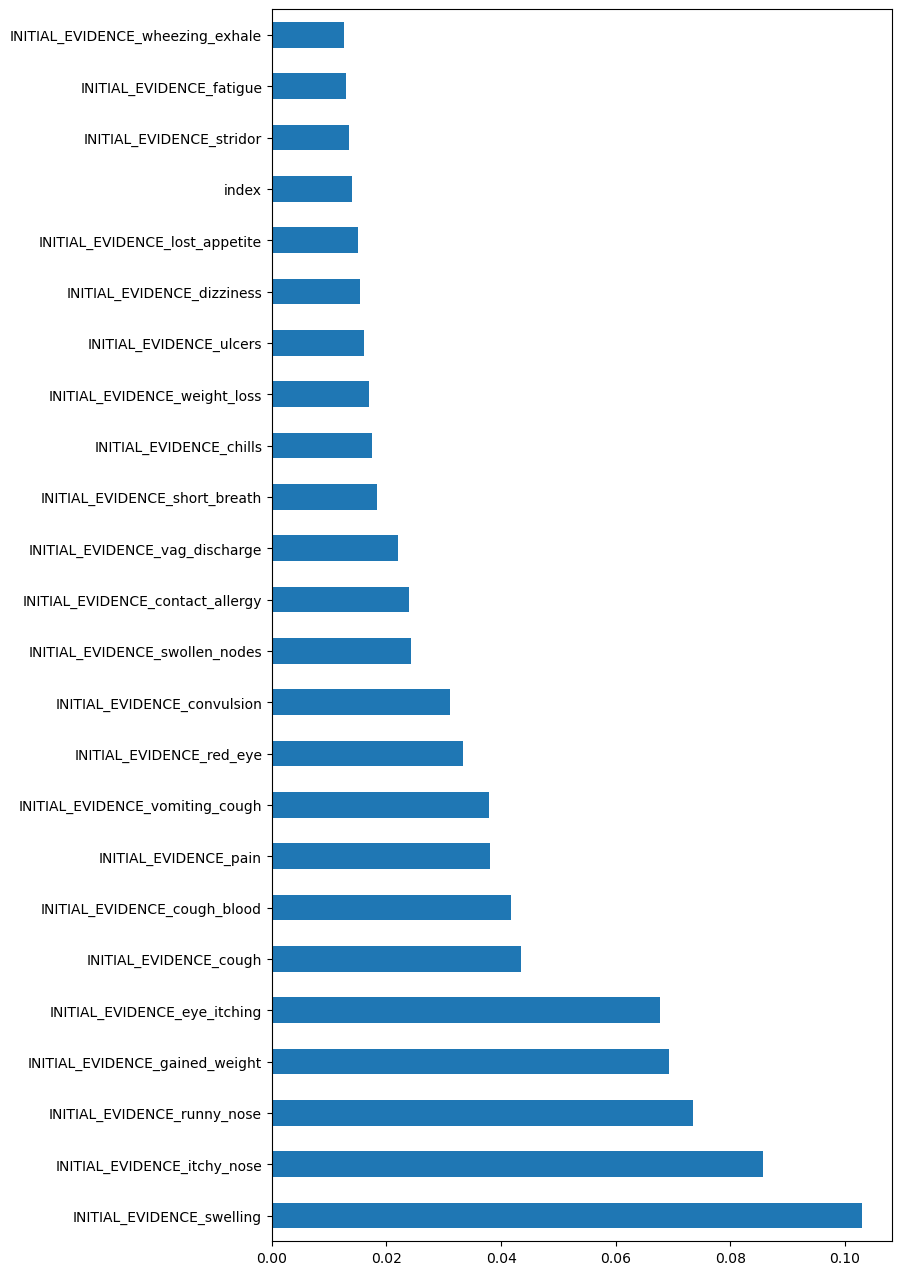

In [12]:
feat_importances = pd.Series(rf1.feature_importances_, index=X_tt.columns)
plt.figure(figsize=(8,16))
feat_importances.nlargest(24).plot(kind='barh')

# Removing index column

- why did it have relatively high feature importance?

In [13]:
rf2 = RandomForestClassifier(
    n_estimators = 500, # number of trees in ensemble
    max_depth = 20, # max_depth of each tree
    min_samples_leaf = 5, 
    bootstrap= True, # sampling with replacement
    max_samples = 2500, # number of training samples selected with replacement to build tree
    random_state = 740 # for consistency
    )

X_ttt = X_tt.drop(columns='index', inplace=False)
X_valval = X_val.drop(columns='index', inplace=False)

In [14]:
rf2.fit(X_ttt, y_tt)
y_pred2 = rf2.predict(X_valval)
print(classification_report(y_val, y_pred2))

                         precision    recall  f1-score   support

     Allergic sinusitis       0.85      0.88      0.86      5668
            Anaphylaxis       0.99      0.39      0.56      6295
                 Chagas       1.00      0.23      0.38      2075
HIV (initial infection)       0.40      0.72      0.52      6573
              Influenza       0.80      0.23      0.36      6080
        Localized edema       0.52      1.00      0.68      6304
                    SLE       1.00      0.30      0.46      2689
            Sarcoidosis       0.58      0.71      0.64      4863
           Tuberculosis       0.58      0.46      0.51      3650
         Whooping cough       1.00      1.00      1.00      1323

               accuracy                           0.61     45520
              macro avg       0.77      0.59      0.60     45520
           weighted avg       0.72      0.61      0.58     45520



<Axes: >

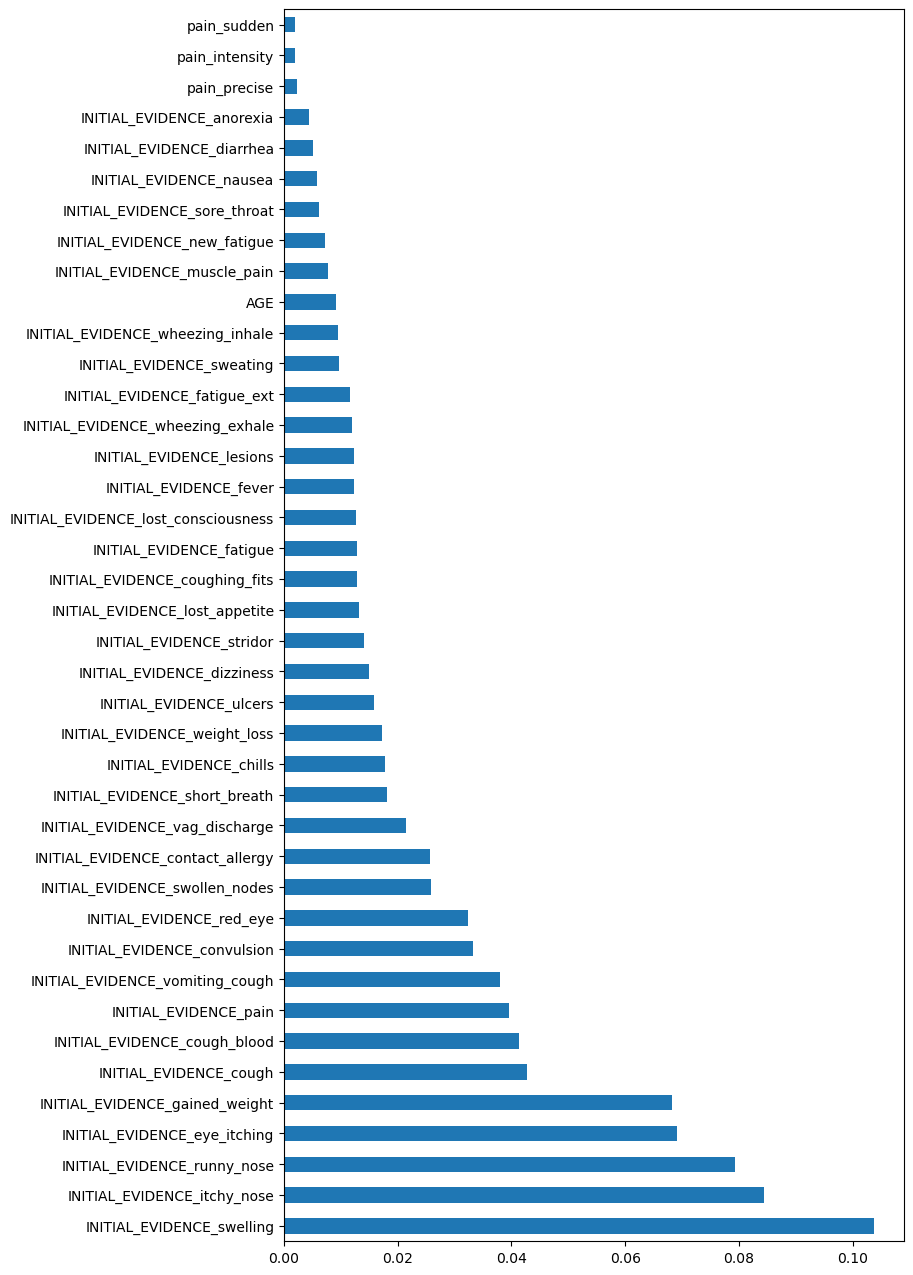

In [88]:
feat_importances = pd.Series(rf2.feature_importances_, index=X_ttt.columns)
plt.figure(figsize=(8,16))
feat_importances.nlargest(40).plot(kind='barh')

# Removing the re-sampling option

In [15]:
rf3 = RandomForestClassifier(
    n_estimators = 500, # number of trees in ensemble
    max_depth = 20, # max_depth of each tree
    min_samples_leaf = 5, 
    bootstrap= False, # sampling with replacement
    max_samples = None, # number of training samples selected with replacement to build tree
    random_state = 740 # for consistency
    )

rf3.fit(X_ttt, y_tt)
y_pred3 = rf3.predict(X_valval)
print(classification_report(y_val, y_pred3))



                         precision    recall  f1-score   support

     Allergic sinusitis       0.85      0.88      0.86      5668
            Anaphylaxis       0.96      0.40      0.56      6295
                 Chagas       1.00      0.23      0.38      2075
HIV (initial infection)       0.41      0.75      0.53      6573
              Influenza       0.87      0.19      0.32      6080
        Localized edema       0.52      1.00      0.68      6304
                    SLE       1.00      0.30      0.46      2689
            Sarcoidosis       0.58      0.69      0.63      4863
           Tuberculosis       0.58      0.47      0.52      3650
         Whooping cough       1.00      1.00      1.00      1323

               accuracy                           0.61     45520
              macro avg       0.78      0.59      0.59     45520
           weighted avg       0.73      0.61      0.58     45520



# Using only initial evidences, age.

In [32]:
initial_evidences = [c for c in X_ttt.columns.values if "INITIAL_EVIDENCE" in c]
initial_evidences.append("AGE")

In [33]:
X_ev_t = X_ttt[initial_evidences]
X_ev_val = X_valval[initial_evidences]

In [36]:
rf4 = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_leaf=5,
    bootstrap=False,
    random_state=740
)

rf4.fit(X_ev_t, y_tt)
pred_ev = rf4.predict(X_ev_val)

In [37]:
print(classification_report(y_val, pred_ev))

/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

     Allergic sinusitis       0.83      0.88      0.85      5668
            Anaphylaxis       0.99      0.39      0.56      6295
                 Chagas       0.00      0.00      0.00      2075
HIV (initial infection)       0.39      0.78      0.52      6573
              Influenza       0.99      0.15      0.26      6080
        Localized edema       0.52      1.00      0.68      6304
                    SLE       1.00      0.30      0.46      2689
            Sarcoidosis       0.58      0.71      0.64      4863
           Tuberculosis       0.59      0.45      0.51      3650
         Whooping cough       1.00      1.00      1.00      1323

               accuracy                           0.59     45520
              macro avg       0.69      0.56      0.55     45520
           weighted avg       0.70      0.59      0.55     45520



/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Simpler

In [63]:
rf0 = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=8)
rf0.fit(X_ttt, y_tt)

RandomForestClassifier(max_depth=8, random_state=42)

In [64]:
y_pred0 = rf0.predict(X_valval)
print(classification_report(y_val, y_pred0))

/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

     Allergic sinusitis       0.85      0.88      0.86      5668
            Anaphylaxis       0.58      0.46      0.51      6295
                 Chagas       0.00      0.00      0.00      2075
HIV (initial infection)       0.37      0.83      0.51      6573
              Influenza       0.99      0.15      0.26      6080
        Localized edema       0.52      1.00      0.68      6304
                    SLE       1.00      0.30      0.46      2689
            Sarcoidosis       0.87      0.45      0.59      4863
           Tuberculosis       0.59      0.45      0.51      3650
         Whooping cough       1.00      0.49      0.66      1323

               accuracy                           0.57     45520
              macro avg       0.68      0.50      0.51     45520
           weighted avg       0.67      0.57      0.53     45520



/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [65]:
from sklearn.tree import export_graphviz
import pydot

In [66]:
# Pull out one tree from the forest
tree = rf0.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, 
                out_file = 'tree.dot', 
                feature_names = X_ttt.columns, 
                rounded = True, 
                precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

# Tuning the hyperparameters

- max_depth: maximum number of levels in each decision tree
- max_features: maximum number of features considered for splitting a node
- n_estimators: number of trees in the forest
- min_samples_split: min number of data points placed in a node before the node is split
- min_samples_leaf: min number of data points allowed in a leaf node
- bootstrap: method for sampling data points (with or without replacement)
- criterion: the function to measure the quality of a split
- random_state
- class_weight: Weights associated with classes in the form {class_label: weight}. For multi-output problems, a list of dicts can be provided in the same order as the columns of y
- ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning. to avoid over-fitting
- max_samples: If bootstrap is True, the number of samples to draw from X to train each base estimator.

In [72]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = [None, 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [100, 500, 1000]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 50, 100]
# Method of selecting samples for training each tree
bootstrap = [True, False]
criterion = ['gini', 'log_loss']
ccp_alpha = [0, 0.001, 0.01, 0.1, 1]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion,
               'ccp_alpha': ccp_alpha}

random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': [None, 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [100, 500, 1000],
 'min_samples_leaf': [10, 50, 100],
 'bootstrap': [True, False],
 'criterion': ['gini', 'log_loss'],
 'ccp_alpha': [0, 0.001, 0.01, 0.1, 1]}

In [74]:
base = RandomForestClassifier()

rf_grid = RandomizedSearchCV(estimator=base,
                             param_distributions=random_grid,
                             n_iter=10,
                             cv=3,
                             verbose=2,
                             random_state=740)

In [75]:
rf_grid.fit(X_ttt, y_tt)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, ccp_alpha=0.1, criterion=log_loss, max_depth=80, max_features=sqrt, min_samples_leaf=50, min_samples_split=500, n_estimators=800; total time= 2.6min
[CV] END bootstrap=False, ccp_alpha=0.1, criterion=log_loss, max_depth=80, max_features=sqrt, min_samples_leaf=50, min_samples_split=500, n_estimators=800; total time= 2.6min
[CV] END bootstrap=False, ccp_alpha=0.1, criterion=log_loss, max_depth=80, max_features=sqrt, min_samples_leaf=50, min_samples_split=500, n_estimators=800; total time= 2.7min
[CV] END bootstrap=False, ccp_alpha=0.01, criterion=gini, max_depth=60, max_features=None, min_samples_leaf=50, min_samples_split=1000, n_estimators=1600; total time=116.7min
[CV] END bootstrap=False, ccp_alpha=0.01, criterion=gini, max_depth=60, max_features=None, min_samples_leaf=50, min_samples_split=1000, n_estimators=1600; total time=62.5min
[CV] END bootstrap=False, ccp_alpha=0.01, criterion=gini, max_dep

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': [0, 0.001, 0.01, 0.1, 1],
                                        'criterion': ['gini', 'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [None, 'sqrt'],
                                        'min_samples_leaf': [10, 50, 100],
                                        'min_samples_split': [100, 500, 1000],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=740, verbose=2)

In [77]:
hyper_params = pd.DataFrame(rf_grid.cv_results_)
hyper_params.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_ccp_alpha,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
9,1580.932503,1866.053303,13.591129,0.441217,2000,500,50,sqrt,110,log_loss,0,True,"{'n_estimators': 2000, 'min_samples_split': 50...",0.608901,0.605885,0.607368,0.607385,0.001231,1
6,149.860834,2.502125,5.702083,0.441963,1200,1000,100,sqrt,70,gini,0.001,True,"{'n_estimators': 1200, 'min_samples_split': 10...",0.607352,0.605012,0.606231,0.606198,0.000955,2
7,13074.304911,14628.234063,5.947313,0.330490,1600,1000,10,None,90,gini,0.001,True,"{'n_estimators': 1600, 'min_samples_split': 10...",0.605786,0.602261,0.602063,0.603370,0.001711,3
3,4720.881542,1542.961564,14.298690,2.973865,1800,100,100,None,30,log_loss,0,True,"{'n_estimators': 1800, 'min_samples_split': 10...",0.602425,0.600926,0.602541,0.601964,0.000735,4
2,245.091012,1.580922,3.839380,0.159281,1200,100,50,sqrt,60,gini,0.01,False,"{'n_estimators': 1200, 'min_samples_split': 10...",0.594385,0.596543,0.592474,0.594467,0.001662,5
4,330.304287,2.574246,5.059545,0.224693,1800,1000,50,sqrt,90,gini,0.01,False,"{'n_estimators': 1800, 'min_samples_split': 10...",0.594616,0.592111,0.586509,0.591079,0.003389,6
5,99.588669,3.458513,3.696626,0.397417,1600,500,100,sqrt,10,gini,0.001,True,"{'n_estimators': 1600, 'min_samples_split': 50...",0.579606,0.580083,0.578057,0.579249,0.000865,7
1,4935.168337,1463.129465,5.804778,0.448450,1600,1000,50,None,60,gini,0.01,False,"{'n_estimators': 1600, 'min_samples_split': 10...",0.498904,0.506582,0.501096,0.502194,0.003229,8
0,155.491622,3.196177,1.209177,0.199359,800,500,50,sqrt,80,log_loss,0.1,False,"{'n_estimators': 800, 'min_samples_split': 500...",0.388513,0.389452,0.388364,0.388776,0.000481,9
8,962.475786,1236.863534,2.108422,1.152229,600,100,50,sqrt,50,gini,1,True,"{'n_estimators': 600, 'min_samples_split': 100...",0.144399,0.144399,0.144399,0.144399,0.000000,10


# Best model

In [100]:
rf_best = RandomForestClassifier(
    n_estimators = 500, # number of trees in ensemble
    max_depth = 20, # max_depth of each tree
    min_samples_leaf = 20, 
    bootstrap= False, # sampling with replacement
    max_samples = None, # number of training samples selected with replacement to build tree
    random_state = 7 # for consistency
    )

In [101]:
rf_best.fit(X_ttt, y_tt)
best_pred = rf_best.predict(X_valval)
print(classification_report(y_val, best_pred))

                         precision    recall  f1-score   support

     Allergic sinusitis       0.85      0.88      0.86      5668
            Anaphylaxis       0.96      0.40      0.56      6295
                 Chagas       1.00      0.23      0.38      2075
HIV (initial infection)       0.41      0.75      0.53      6573
              Influenza       0.85      0.20      0.32      6080
        Localized edema       0.52      1.00      0.68      6304
                    SLE       1.00      0.30      0.46      2689
            Sarcoidosis       0.58      0.70      0.63      4863
           Tuberculosis       0.58      0.46      0.52      3650
         Whooping cough       1.00      1.00      1.00      1323

               accuracy                           0.61     45520
              macro avg       0.77      0.59      0.59     45520
           weighted avg       0.73      0.61      0.58     45520

